In [ ]:
!pip install -q pylibxc2
!pip install -q ipyvolume

     |████████████████████████████████| 26.4 MB 1.7 MB/s 
     |████████████████████████████████| 2.9 MB 4.5 MB/s 
     |████████████████████████████████| 260 kB 38.7 MB/s 
     |████████████████████████████████| 3.3 MB 24.8 MB/s 
     |████████████████████████████████| 1.6 MB 46.1 MB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 


In [ ]:
#@title Import Packages
#dependencies
from IPython import display
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import ipyvolume as ipv
import pylibxc
import ipywidgets as widgets
from scipy import sparse         
from scipy.sparse.linalg import eigsh
import seaborn as sns
from termcolor import cprint
from google.colab import output
output.enable_custom_widget_manager()
%config InlineBackend.figure_format = 'svg'

In [ ]:
#@title Box Parameters
# Box Dimensions in Bohr
ang_to_bohr = 1.889726
box_dimA = np.array([8.0, 4.0, 1.0])
box_dimB = box_dimA * ang_to_bohr
lx, ly, lz = box_dimB

# number of Pi electrons in system
print('Please enter integer values for')
print('===================================')
num_elect = int(input('Number of electrons (2,4,6,...,26): '))
print('-----------------------------------')
#num_elect = 6 + (ring-1)*4
occ = num_elect/2
levels = int(occ + 2)

#find out length parameters
print('Box lengths (Bohr)')
lx = int(input('lx: '))
ly = int(input('ly: '))
lz = int(input('lz: '))




# 3d grid of points
nx, ny, nz = 5*lx, 5*ly, 5*lz
xp = np.linspace(0, lx, nx)
yp = np.linspace(0, ly, ny)
zp = np.linspace(0, lz, nz)

#construct 3d grid of points
X, Y, Z = np.meshgrid(xp, yp, zp, indexing='ij')

Please enter integer values for
Number of electrons (2,4,6,...,26): 14
-----------------------------------
Box lengths (Bohr)
lx: 16
ly: 8
lz: 2


#### Define Numerical Integration

$$I(f(x,y,z))=\int_0^{l_z} \int_0^{l_y} \int_0^{l_x} f(x,y,z)dxdydz$$


In [ ]:
#@title
integ_3d = lambda psi_3d: np.sum(psi_3d*xp[1]*yp[1]*zp[1]) 

# Hamiltonian

$$\hat{H}=\hat{T}+\hat{V}\\
\hat{T}=-\frac{1}{2}\nabla^2\\
\hat{V}[\rho(r)]=v_{Ha}[\rho(r)]+v_{x}[\rho(r)]+v_{c}[\rho(r)]
$$

## Kinetic Energy of Noninteracting Particles



To start, consider the kinectic energy operator of non-interacting electrons

$$\hat{T}=-\frac{1}{2}\nabla^2=-\frac{1}{2}\frac{d^2}{dx^2}-\frac{1}{2}\frac{d^2}{dy^2}-\frac{1}{2}\frac{d^2}{dz^2}$$

The finite difference method can be used to represent the laplacian in 3d. For the x-dimension this has the form

$$\frac{d^2\psi}{dx^2}=\frac{\psi _{i+1,j,k}-2\psi _{i,j,k}+\psi _{i-1,j,k}}{\Delta x^2}$$

or in a matrix representation

$$\frac{d^2}{dx^2}=\frac{1}{\Delta x^2}\begin{bmatrix}
-2 & 1 & 0 & \dots & 0\\ 
1 & -2 & 1 & \dots & 0 \\
0 & 1 & -2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & -2 \\
\end{bmatrix}$$

In three dimension the overall operator can be expressed with a kronecker sum

$$\hat{T}=\hat{T_x}\bigoplus\hat{T_y}\bigoplus\hat{T_z}$$

In [ ]:
#@title
diag1x = np.ones(nx)/(xp[1])
diag1y = np.ones(nx)/(yp[1])
diag1z = np.ones(nx)/(zp[1])

D1x = sparse.spdiags(np.array([-diag1x, diag1x]), np.array([0,1]), nx, nx)
D1y = sparse.spdiags(np.array([-diag1y, diag1y]), np.array([0,1]), ny, ny)
D1z = sparse.spdiags(np.array([-diag1z, diag1z]), np.array([0,1]), nz, nz)

D1st = sparse.kronsum(D1z,sparse.kronsum(D1y,D1x))


diagx = np.ones(nx)/(xp[1]**2)
diagy = np.ones(ny)/(yp[1]**2)
diagz = np.ones(nz)/(zp[1]**2)
Dx = sparse.spdiags(np.array([diagx, -2*diagx, diagx]), np.array([-1,0,1]), nx, nx)
Dy = sparse.spdiags(np.array([diagy, -2*diagy, diagy]), np.array([-1,0,1]), ny, ny)
Dz = sparse.spdiags(np.array([diagz, -2*diagz, diagz]), np.array([-1,0,1]), nz, nz)

# construct the sparse matrix 
T = -1/2 * sparse.kronsum(Dz,sparse.kronsum(Dy,Dx))

#k will change depnding on number of electrons
# find the eigenvalues and eigenvectors
free_p_eval, free_p_evec = eigsh(T, k=levels, which='SM',mode='cayley',tol=0.00001)


## function to unpack eigenvalues and get density
def find_psi_rho(e_vecs):
    norm_psi = np.zeros_like(e_vecs)
    el_den = np.zeros_like(e_vecs[:,0])
    for i in range(e_vecs.shape[1]):
        norm_psi[:,i] = e_vecs[:,i]/np.sqrt(integ_3d(e_vecs[:,i]**2))
    for i in range(e_vecs.shape[1]-2):
        el_den += 2* norm_psi[:,i]**2
    return norm_psi, el_den
free_psi, free_e_den = find_psi_rho(free_p_evec)

In [ ]:
#@title Plot Non-interacting Density
label = "\033[1mNon-interacting electron density"
print(len(label)*'-')
print("\033[1mNon-interacting electron density")
print(len(label)*'-')

ipv.clear()
fig = ipv.figure(width=800, height=800)
ipv.plot_isosurface(free_e_den.reshape(nx,ny,nz),level=free_e_den.mean()*2)
ipv.view(0,-75)
ipv.squarelim()
ipv.show()
print(' \033[4misovalue slider (e/Bohr**3)')

------------------------------------
Non-interacting electron density
------------------------------------


 isovalue slider (e/Bohr**3)


# Electron Density

To find the electron density, we normalize the eigenfunctions from eigh, then sum over the occupied states

$$\psi(r) = \frac{\psi_{raw}(r)}{\sqrt{\int\psi_{raw}^2(r)dr}}$$

$$\rho (r)=2\sum_n^{occ} \lvert \psi(r) \rvert ^2 $$

In [ ]:
#sanity check that the e_density integrates to the number of electrons (14)
np.sum(free_e_den*xp[1]*yp[1]*zp[1])

13.999999999999998

# Hartree Potential


The expressions for hartree energy and potential are

$$ E_{Ha}[\rho(r)]=\frac{1}{2}\iint \frac{\rho(r)\rho(r')}{\sqrt{(r-r')^2}}drdr'$$

$$ v_{Ha}=\int \frac{\rho(r)}{\sqrt{(r-r')^2}}dr$$

Instead of performing these integrations directly, which is memory-intensive with the number of grid points, poisson's equation can be used

$$ \nabla^{2}v_{Ha}=-4 \pi \rho(r)$$

then the hartree potential integrated with the electron density to obtain the hartree energy
$$ E_{Ha}=\frac{1}{2}\int v_{Ha}\rho(r)dr $$

In [ ]:
#@title 
#takes flattened electron density as input and returns
#flat hartree potential and energy

def hartree(den):
  v_ha_flat = sparse.linalg.bicg(-2*T,-4.*np.pi*den)[0]
  v_ha_ener = (1/2)*integ_3d(v_ha_flat*den)
  return v_ha_flat, v_ha_ener

# LDA Exchange

> Unlike the expressions for other functionals, LDA exchange has a simple analytical form (https://link.aps.org/doi/10.1103/PhysRevA.37.1895)

Exchange Energy

$$ E_X^{LDA}[\rho(r)] =  \int v_X^{LDA}\rho(r) dr$$
Exchange Potential
$$ v_X^{LDA}[\rho(r)] =  -\frac{3}{4}\left(\frac{3}{\pi}\right)^{1/3} \rho(r)^{1/3}$$

In [ ]:
#@title
def lda_exchange(den):
  exch_pot = -(3/4)*(3/np.pi)**(1/3)*abs(den)**(1/3)
  exch_e = -(3/4)*(3/np.pi)**(1/3)*integ_3d(den**(4/3))  
  return exch_pot, exch_e

# LDA Correlation


> Correlation is more complicated than exchange, but we can use the simple uniform electron gas correlation (https://doi.org/10.1063/1.4958669)

Energy from correlation can be obtained through integration

$$ E_{cor}^{LDA}=\int v_{cor}\rho(r)dr $$

Correlation potential

$$ v_{cor}^{LDA}(r_s)= a\cdot ln\left(1+\frac{b}{r_s}+\frac{b}{r_s^2}\right)$$ 
where:
$$ r_s = \left(\frac{3}{4\pi\rho}\right)^{1/3} $$ \\

$$ a = \frac{ln2-1}{2\pi^2}$$ \\

$$ b \approx 20.4562557 $$

In [ ]:
#@title
def lda_correlation(den):
    ## paper: 10.1063/1.4958669
    a = (np.log(2)-1)/(2*np.pi**2)
    b = 20.4562557
    c = (4*np.pi/3)**(1/3)
    corr_pot = a*np.log(1 + b*c*den**(1/3) + b*(c**2)*den**(2/3))
    corr_en = integ_3d(den*corr_pot)
    return corr_pot.flatten(), corr_en

# GGA (PBE) Exchange
> (https://doi.org/10.1103/PhysRevLett.77.3865) 

Exchange energy 
$$ E_X^{GGA}=\int v_X^{LDA}F_x(s)\rho(r)dr $$ \\
$$ F_x(s)= 1+ \kappa -\frac{\kappa}{\left(1+\frac{\mu s^2}{\kappa}\right)}$$ \\
$$ s = \frac{\left|\nabla\rho(r)\right|}{2\cdot3^{1/3}\pi^{2/3}\rho(r)^{4/3}} $$ \\
Exchange potential
$$ v_X^{GGA} = v_x^{LDA}F_x(s)$$

In [ ]:
#@title
RDG = lambda e_den: (1/(2*3**(1/3)*np.pi**(2/3))) * abs(D1st.dot(e_den)) / (e_den**(4/3))
def pbe_exchange(den):
    clean_den = np.ma.array(den, mask= den < 0.00000001 )
    den = clean_den
    ### paper: 10.1103/PhysRevLett.77.3865
    #exch_pot = -(3/np.pi)**(1/3)*abs(den)**(1/3)
    kappa = 0.804
    mu = 0.2195149727645171
    s = RDG(den)
    #s = np.ma.array(s, mask = s < 0.000001)
    F_xs = 1 + kappa - kappa / (1 + mu * s**2 / kappa)
    exch_pot = F_xs * -(3/4)*(3/np.pi)**(1/3)*(den**(1/3)) 
    exch_e = integ_3d(den*exch_pot)
    return exch_pot, exch_e

# GGA (PBE) Correlation
> (https://doi.org/10.1103/PhysRevLett.77.3865)

Correlation energy
$$ E_{corr}^{GGA} = \int \left[v_{corr}^{LDA}(r_s)+H(r_s,t)\right]\rho(r)dr$$ \\
$$ H = \gamma\times ln\left\{1+\frac{\beta}{\gamma}t^2\left[\frac{1+At^2}{1+At^2+A^2t^4}\right]\right\}$$ \\
$$ A = \frac{\beta}{\gamma}\left[exp\left\{\frac{-v_{corr}^{LDA}}{\gamma}\right\}-1\right]^{-1}$$ \\
$$ t = \frac{\left|\nabla\rho(r)\right|\pi^{1/6}}{4\cdot3^{1/6}\rho(r)^{7/6}}$$ \\

Correlation potential
$$ v_{corr}^{GGA}=v_{corr}^{LDA}(r_s)+H(r_s, t)$$

In [ ]:
#@title
def pbe_correlation(den):
    #lda_c_pot = pylibxc_lda_correlation(den)[0]
    clean_den = np.ma.array(den, mask= den < 0.00000001 )
    den = clean_den
    lda_c_pot = lda_correlation(den)[0]
    beta = 0.06672455060314922
    gamma = 0.031090690869654894
    A = (beta/gamma)*((np.exp(-lda_c_pot/gamma)-1)**(-1))
    d_g = D1st.dot(den)
    t = (abs(d_g)*np.pi**(1/6))/(4*3**(1/6)*den**(7/6))
    H = gamma*np.log(1+(beta/gamma)*t**2*((1+A*(t**2))/(1+A*(t**2)+(A**2)*(t**4))))
    corr_pot = lda_c_pot + H
    corr_e = integ_3d(den*corr_pot)
    return corr_pot, corr_e

# KS Equation Iterations

In [ ]:
#@title
density_matrix_dict = {}

# Total DFT energy:

$$ E_{total}^{DFT}= E_{Kin} + E_{Ha} + E_X + E_{C} $$

In [ ]:
#@title Define Hamiltonian (execute cell first)
functional_w = widgets.Select(options=['LDA', 'GGA'],value='LDA',description='Functional:')
hartree_w = widgets.Select(options=['ON','OFF'],description='Hartree:')
exchange_w = widgets.Select(options=['ON','OFF'],value='ON',description='Exchange:')
correlation_w = widgets.Select(options=['ON','OFF'],value='ON',description='Correlation:')
display.display(functional_w)
display.display(hartree_w)
display.display(exchange_w)
display.display(correlation_w)

Select(description='Functional:', options=('LDA', 'GGA'), value='LDA')

Select(description='Hartree:', options=('ON', 'OFF'), value='ON')

Select(description='Exchange:', options=('ON', 'OFF'), value='ON')

Select(description='Correlation:', options=('ON', 'OFF'), value='ON')

In [ ]:
#@title Solve KS Equations in SCF Loop
key = f'{functional_w.value}_Ex_{exchange_w.value}_Cor_{correlation_w.value}_Har_{hartree_w.value}'
ener_log = [0]
Gap_DFT = []
Gap_DFT_ev = []
e_levels=[0]
density_matrix=[]
e_tol = 1e-5
max_iter = 35
inter_e_den = np.zeros_like(free_e_den)
columns = ['E_total', 'E_KE', 'E_x', 'E_c', 'E_ha']
df = pd.DataFrame(columns =['#i', 'E_tot'.center(8, "-"), 'E_KE'.center(8, "-"), 'E_x'.center(8, "-"), 'E_c'.center(8, "-"), 'E_ha'.center(8, "-")])
display.display(df)
num_orbitals = int(num_elect)/2+2
for i in range(max_iter):
    

    
    if hartree_w.value == 'ON':
        har_pot, har_ener = hartree(inter_e_den)
    elif hartree_w.value == 'OFF':
        har_pot = 0
        har_ener = 0

    if exchange_w.value == 'ON':    
      if functional_w.value == 'LDA':
        exc_pot, exc_ener = lda_exchange(inter_e_den)
      elif functional_w.value == 'GGA':
        exc_pot, exc_ener = pbe_exchange(inter_e_den)
    elif exchange_w.value == 'OFF':
      exc_pot = 0
      exc_ener = 0
    
    if correlation_w.value == 'ON':    
      if functional_w.value == 'LDA':
        cor_pot, cor_ener = lda_correlation(inter_e_den)
      elif functional_w.value == 'GGA':
        cor_pot, cor_ener = pbe_correlation(inter_e_den)
    elif correlation_w.value == 'OFF':
        cor_pot = 0
        cor_ener = 0 




    V = sparse.diags(har_pot + exc_pot + cor_pot)

    H = T + V

    inter_e_val, inter_e_vec = eigsh(H, k=int(num_orbitals), which='SM',mode='cayley',tol=0.00001)
    
    
    
    e_total = 2*sum(inter_e_val[:-1]) - har_ener
    ke = 2*sum(inter_e_val[:-1]) - 2*har_ener - (exc_ener + cor_ener)
    ener_log.append(e_total) 
    e_levels.append(inter_e_val)
    density_matrix.append(inter_e_vec)
    e_diff= e_total - ener_log[i]
    dm = pd.DataFrame(columns =[str(i).zfill(2), "{:.5f}".format(e_total),
                                "{:.5f}".format(ke), "{:.5f}".format(exc_ener),
                                "{:.5f}".format(cor_ener), "{:.5f}".format(har_ener)])
    display.display(dm)

    n_psi, new_den = find_psi_rho(inter_e_vec)
    old_den = inter_e_den.copy()
    inter_e_den = 0.5*new_den + 0.5*old_den
    Gap_DFT.append(round(float(inter_e_val[:,None][-2] - inter_e_val[:,None][-3]), 3))
    Gap_DFT_ev.append(round(float(inter_e_val[:,None][-2] - inter_e_val[:,None][-3])*27.2114, 3))


    if abs(e_diff) < e_tol:
        density_matrix_dict[key]=inter_e_vec
        cprint('======================================================\n','blue',attrs=['bold'])
        cprint('----Converged!----\n','cyan',attrs=['bold'])
        print('KS orbital energies are: \n')
        print(inter_e_val[:,None])
        Gap = inter_e_val[:,None][-2] - inter_e_val[:,None][-3]
        Gap_ev = Gap*27.2114
        print(f'The HOMO-LUMO gap is: {float(Gap):.4f} Ha ({float(Gap_ev):.4f} eV)')
        break
                
else:
    print("not converged :(")

,#i,-E_tot--,--E_KE--,--E_x---,--E_c---,--E_ha--


,00,18.01822,18.01822,-0.00000,0.00000,0.00000


,01,16.75256,17.84374,-1.76939,-0.31514,0.99335


,02,17.04381,18.40421,-3.00957,-0.49942,2.14859


,03,17.05904,18.48218,-3.66874,-0.59383,2.83943


,04,17.03551,18.47679,-4.00407,-0.64136,3.20415


,05,17.01645,18.46515,-4.17181,-0.66512,3.38823


,06,17.00522,18.45797,-4.25509,-0.67697,3.47930


,07,16.99922,18.45442,-4.29630,-0.68287,3.52396


,08,16.99613,18.45282,-4.31666,-0.68580,3.54576


,09,16.99456,18.45214,-4.32671,-0.68726,3.55639


,10,16.99377,18.45186,-4.33167,-0.68798,3.56157


,11,16.99338,18.45175,-4.33412,-0.68834,3.56409


,12,16.99318,18.45172,-4.33533,-0.68852,3.56532


,13,16.99309,18.45171,-4.33593,-0.68861,3.56592


,14,16.99304,18.45171,-4.33623,-0.68866,3.56622


,15,16.99301,18.45171,-4.33637,-0.68868,3.56636


,16,16.99300,18.45171,-4.33645,-0.68869,3.56643


,17,16.99299,18.45171,-4.33648,-0.68870,3.56646



----Converged!----

KS orbital energies are: 

[[1.09625639]
 [1.14411074]
 [1.22671371]
 [1.26479336]
 [1.31345096]
 [1.34113171]
 [1.39718576]
 [1.49608531]
 [1.51122524]]
The HOMO-LUMO gap is: 0.0989 Ha (2.6912 eV)


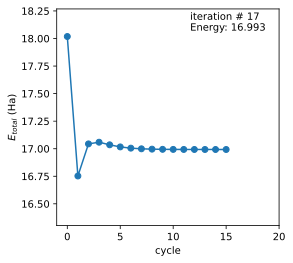

In [ ]:
#@title Total Energy Plot
for i in range(0,len(ener_log[1:])):
    fig = plt.figure(figsize=(4,4),dpi=200,frameon=False)
    plt.tight_layout()
    plt.cla()
    display.clear_output(wait=True)
    plt.ylabel('$E_{total}$ (Ha)')
    plt.xlabel('cycle')
    plt.plot(ener_log[1:i],'o-')
    ax = plt.axes()
    plt.text(0.60,0.95,f'iteration # {i}',transform=ax.transAxes)
    plt.text(0.60,0.90,f'Energy: {ener_log[i+1]:.3f}',transform=ax.transAxes)
    plt.xlim([-1, 20])
    plt.ylim([min(ener_log[1:])-0.45, max(ener_log[1:])+0.25])
    plt.pause(1)
    #plt.text(4.5,16.3,"Energy converged in " + str(len(ener_log)-2) + " cycles")
    
    
plt.show()

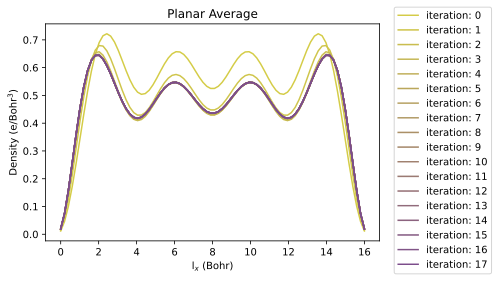

In [ ]:
#@title Density Slice
it_num_max = len(density_matrix)

color1 = "#D4CC47"
color2 = "#7C4D8B"
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]
def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

colors = get_color_gradient(color1, color2, it_num_max)

for i in range(it_num_max):
  density = find_psi_rho(density_matrix[i])[1].reshape(nx,ny,nz)
  density_slice = density[:,int(ny/2),5]
  den_slice_sum = np.zeros_like(density_slice)
  for j in range(nz):
    den_slice_sum += density[:,int(ny/2),j]
  plt.plot(xp,den_slice_sum,label=f'iteration: {i}',color=colors[i])
  plt.title('Planar Average')
  plt.ylabel('Density (e/Bohr$^{3}$)')
  plt.xlabel('l$_x$ (Bohr)')
  plt.legend(bbox_to_anchor=(1.35, 1.1))
#plt.plot(xp,GGA_slice,label ='GGA slice')
#plt.legend()

In [ ]:
#@title Noninteracting Density
noninter_den = find_psi_rho(density_matrix[0])[1].reshape(nx,ny,nz)
noninter_den_iso = noninter_den.mean()*2
print('\033[1m==============================\033[0m')
print("\033[1m\033[94mElectron density @ iteration 0\033[0m")
print('\033[1m==============================\033[0m')
print(f'isovalue:\033[0m {noninter_den_iso:.5f} e/Bohr**3')
ipv.clear()
fig = ipv.figure(width=500, height=500)
ipv.plot_isosurface(noninter_den,level=noninter_den_iso,controls=False)
ipv.squarelim()
ipv.show()

Electron density @ iteration 0
isovalue: 0.09478 e/Bohr**3


In [ ]:
#@title DFT Relaxed Density
relax_den = find_psi_rho(density_matrix[-1])[1].reshape(nx,ny,nz)
print('\033[1m===============================\033[0m')
print(f"\033[1m\033[94mElectron density @ iteration {it_num_max-1}\033[0m")
print('\033[1m===============================\033[0m')
print(f'isovalue:\033[0m {noninter_den_iso:.5f} e/Bohr**3')
ipv.clear()
fig = ipv.figure(width=500, height=500)
ipv.plot_isosurface(relax_den,level=noninter_den_iso,controls=False)
ipv.squarelim()
ipv.show()

Electron density @ iteration 17
isovalue: 0.09478 e/Bohr**3


# PIB Energy Comparison 

$$\psi_{n_x,n_y,n_z}=\sqrt{\frac{8}{l_xl_yl_z}}\sin\bigg(\frac{n_x\pi x}{l_x}\bigg)\sin\bigg(\frac{n_y\pi y}{l_y}\bigg)\sin\bigg(\frac{n_z\pi z}{l_z}\bigg)\\
E_{n_x,n_y,n_z}= \frac{\pi^2}{4}\bigg[\bigg(\frac{n_x}{l_x}\bigg)^2 + \bigg(\frac{n_y}{l_y}\bigg)^2 + \bigg(\frac{n_z}{l_z}\bigg)^2\bigg]\\
$$


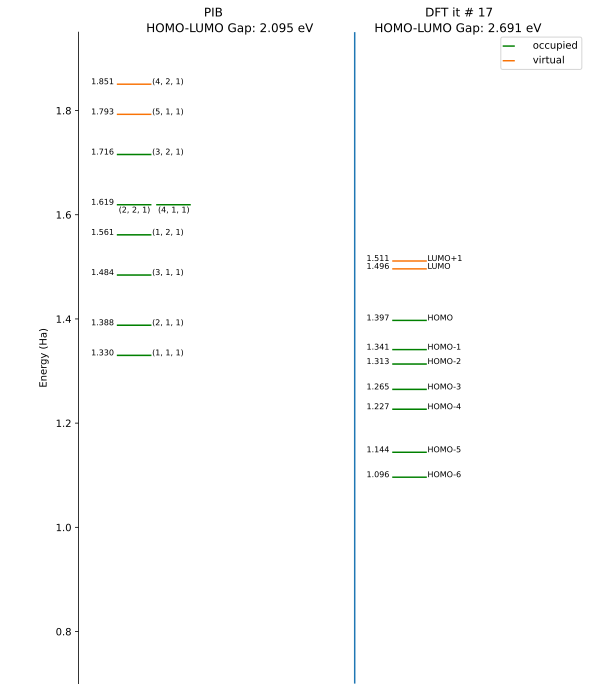

In [ ]:
#@title PIB Energy Plot Comparison
def psi_ener(qnx, qny, qnz, lx, ly, lz):
    e_level = (np.pi**2/2)*((qnx/lx)**2 + (qny/ly)**2 + (qnz/lz)**2)
    return e_level
  
ener_list = []

for i in range(1,20):
    for j in range(1,20):
        for k in range(1,20):
            ener_list.append(((i,j,k),psi_ener(qnx=i,qny=j,qnz=k, lx=lx, ly=ly, lz=lz)))

ener_list.sort(key=lambda x: abs(x[1]))
ener_list = np.asarray(ener_list,dtype=object)
ener_list[:,1] = ener_list[:,1].astype(dtype=float)

degen_list = np.unique(ener_list[:,1],return_counts=True)

degen_log = np.array([],dtype=int)

for i in degen_list[1]:
    degen_log = np.append(degen_log, i*np.ones(i,dtype=int))

degen_log = degen_log.reshape(len(degen_log),1)

ener_list = np.hstack((ener_list,degen_log))

#################find the unoccupied levels##############
occ_levels = int((num_elect/ 2))
occ_states = ener_list[0:occ_levels]
occ_degen_accounted = np.where(occ_states[-1,1] == occ_states[:,1])[0].size
occ_state_miss = occ_states[-1,2] - occ_degen_accounted
if occ_state_miss > 0:
    occ_levels = occ_levels + occ_state_miss
    occ_states = ener_list[0:occ_levels]
##################find the occupied levesl############
unocc_levels = 2
unocc_states = ener_list[occ_levels:occ_levels+unocc_levels]
unocc_degen_accounted = np.where(unocc_states[-1,1] == unocc_states[:,1])[0].size
unocc_state_miss = unocc_states[-1,2] - unocc_degen_accounted
if unocc_state_miss > 0:
    unocc_levels = unocc_levels + unocc_state_miss
    unocc_states = ener_list[occ_levels:occ_levels + unocc_levels]
occ = []
unocc = []
energy_PIB = []
for state in occ_states:
    occ.append(state[0])
    energy_PIB.append(round(state[1],8))
for state in unocc_states:
    unocc.append(state[0])
    energy_PIB.append(round(state[1],8))
PIBlevels = occ + unocc

yPIB = np.array(energy_PIB)
xPIB = np.ones(yPIB.shape[0])
for i in range(0,len(yPIB)):
    #print(yPIB[i])
    if yPIB[i] in yPIB[:i]:
        #print('Yes')
        #print(yPIB[:i])
        count = list(yPIB[:i]).count(yPIB[i])
        #print(count)
        xPIB[i] += count*0.3
Gap_PIB = round(energy_PIB[len(occ)] - energy_PIB[len(occ)-1], 3)
Gap_PIB_ev = round(Gap_PIB*27.2114, 3)



for i in range(1,len(e_levels[:-1])):
  occ2 = int(int(num_elect)/2)
  y_DFT = e_levels[i][:,None]
  x_DFT = 3.1*np.ones(y_DFT.shape[0])
  fig = plt.figure(figsize=(8, 12))
  ax = fig.add_subplot(1, 1, 1)
  plt.cla()
  display.clear_output(wait=True)
  plt.ylabel("Energy (Ha)",labelpad=7)
  plt.scatter(xPIB[:len(occ)],yPIB[:len(occ)],marker=0,s=1200,linewidths=6, color='green')
  plt.scatter(xPIB[len(occ):],yPIB[len(occ):],marker=0,s=1200,linewidths=6, color='#F97306')
  plt.scatter(x_DFT[:occ2],y_DFT[:occ2],marker=0,s=1200,linewidths=6, color='green', label='occupied')
  plt.scatter(x_DFT[occ2:],y_DFT[occ2:],marker=0,s=1200,linewidths=6, color='#F97306', label='virtual')
  plt.legend(bbox_to_anchor=(1.3, 1))
  plt.rcParams["legend.markerscale"] = 0.35
  plt.xticks([])
  plt.xlim([-0.1,3.3])
  plt.ylim([0.7,max(yPIB)+0.1])
  plt.text(x_DFT[0]-0.4, max(yPIB)+0.10,f'HOMO-LUMO Gap: {Gap_DFT_ev[i]:.3f} eV', size=12)
  annotations = [str(x) for x in PIBlevels]
  plt.text(x_DFT[0]-0.013, max(yPIB)+0.13, f'DFT it # {i}', size=12)
  for i, label in enumerate(annotations):
      if list(yPIB).count(yPIB[i])==1:
          plt.annotate(label, (xPIB[i] + 0.005, yPIB[i]),size=8)
          plt.text(xPIB[i]-0.46, yPIB[i], "{:.3f}".format(yPIB[i]),size=8)
      else:
          plt.annotate(label, (xPIB[i] - 0.25, yPIB[i] - 0.015),size=8)
          if yPIB[i] not in yPIB[:i]:
              plt.text(xPIB[i]-0.46, yPIB[i], "{:.3f}".format(yPIB[i]),size=8)
              #plt.text(xt[i]-0.2, yt[i] + 0.015, "{:.3f}".format(yt[i]),size=8)

  annotationsDFT = ['HOMO-'+str(i) for i in range(occ2)]
  annotationsDFT[0] = 'HOMO'
  annotationsDFT.insert(0,'LUMO')
  annotationsDFT.insert(0,'LUMO+1')
  #annotationsDFT = ["HOMO-6","HOMO-5","HOMO-4","HOMO-3","HOMO-2","HOMO-1","HOMO","LUMO"]
  for i, label in enumerate(reversed(annotationsDFT)):
      plt.annotate(label, (x_DFT[i] + 0.005, y_DFT[i]),size=8)
      plt.text(x_DFT[i]-0.46, y_DFT[i], "{:.3f}".format(y_DFT[i][0]), size=8)
  plt.axvline(x=2.55)
  plt.text(xPIB[0]+0.4, max(yPIB)+0.13, 'PIB', size=12)
  plt.text(xPIB[0]-0.04, max(yPIB)+0.10,f'HOMO-LUMO Gap: {Gap_PIB_ev:.3f} eV', size=12)
  ax.spines['left'].set_position(('axes', .16))
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.pause(1)